In [1]:
from ipywidgets import interactive
import ipywidgets as widgets

import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
%matplotlib inline

In [243]:
INTER_FRAME = 1
FRAME_COUNT = 5
BEGIN_FRAME = 1014 # 2981

In [425]:
img.shape

(360, 490, 3)

In [244]:
import cv2
vidcap = cv2.VideoCapture('road.mp4')
success,image = vidcap.read()
count = 0
success = True
images = []
for i in range(BEGIN_FRAME + FRAME_COUNT*INTER_FRAME+1):
    success,image = vidcap.read()
    if i % INTER_FRAME == 0 and i > BEGIN_FRAME:
        images.append(image)

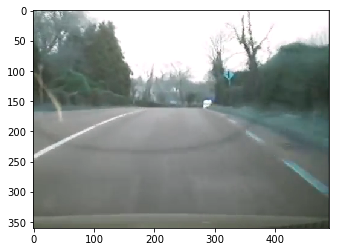

In [246]:
plt.imshow(images[0])

In [247]:
def intersection(cos1, sin1, cos2, sin2, rho1, rho2):
    D  = cos1 * sin2 - cos2 * sin1
    Dx = rho1 * sin2 - rho2 * sin1
    Dy = cos1 * rho2 - cos2 * rho1
    if D != 0:
        x = Dx / D
        y = Dy / D
        return x,y
    else:
        return False

In [248]:
top_lines = 20
blur_size = 9
hough_treshold = 50
hough_top_lines = 20
vanishing_box = [width*0.25, width*0.75, height*0, height*0.75]
edge_threshold = 64
theta_limit = 70

In [419]:
#img = cv2.imread('curveRight4.jpg', cv2.IMREAD_COLOR)
#img = cv2.imread('solidWhiteRight.jpg', cv2.IMREAD_COLOR)
img = images[0]

def extract_vanishing_point_and_edges(img, top_lines, blur_size, hough_treshold, vanishing_box, edge_threshold, theta_limit, crop_top=80):
    height, width = img.shape[:2]
    img = img[crop_top:]
    height, width = img.shape[:2]
    M = cv2.getRotationMatrix2D((width/2,height/2),0,1)
    img = cv2.warpAffine(img,M,(width,height))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (blur_size, blur_size), 0, 0)

    edges = cv2.Sobel(blur, cv2.CV_8UC1, 1, 0,
                      ksize=3,
                      scale=1,
                      delta=0,
                      borderType=cv2.BORDER_DEFAULT)
    edges = cv2.multiply(edges, alpha[crop_top:], dtype=cv2.CV_8UC1)

    _, edges_threshold = cv2.threshold(edges, edge_threshold, 0, cv2.THRESH_TOZERO)


    polar_theta_limit = theta_limit*np.pi/180
    polar_lines = cv2.HoughLines(edges_threshold,1,np.pi/180,hough_treshold, min_theta=-polar_theta_limit,max_theta=+polar_theta_limit)

    intersections = []

    left_lines, right_lines = [], []
    lines = []
    for [[rho,theta]] in polar_lines:
        #lines.append((np.cos(theta), np.sin(theta), rho, theta))
        c, s = np.cos(theta), np.sin(theta)
        #top_x, _ = intersection(c, s, 0, 1, 0)
        bot_x, _ = intersection(c, s, 0, 1, rho, height)
        if theta > 0 and bot_x < width/2: # is tilted to the right and starts from the left part of the screen
            left_lines.append((c, s, rho, theta))
        elif theta < 0 and bot_x > width/2: # is tilted to the left and starts from the right part of the screen
            right_lines.append((c, s, rho, theta))

    left_thetas, right_thetas = [], []
    correct_left_lines, correct_right_lines = set(), set()
    brk = False
    for i, (cos1, sin1, rho1, theta1) in enumerate(left_lines):
        for j, (cos2, sin2, rho2, theta2) in enumerate(right_lines):
            res = intersection(cos1, sin1, cos2, sin2, rho1, rho2)
            if res is not False and vanishing_box[0] < res[0] < vanishing_box[1]\
                                and vanishing_box[2] < res[1] < vanishing_box[3]:
                if len(correct_left_lines) < top_lines:
                    correct_left_lines.add(i)
                if len(correct_right_lines) < top_lines:
                    correct_right_lines.add(j)
                brk = len(correct_left_lines) >= top_lines and len(correct_right_lines) >= top_lines
            if brk:
                break
        if brk:
            break
    correct_left_lines = sorted(list(correct_left_lines))
    correct_right_lines = sorted(list(correct_right_lines))

    best_left = correct_left_lines[:top_lines]#sorted(correct_left_lines, key=lambda x:left_lines[x][3])[:top_lines]#/len(correct_left_lines)
    left_theta = sum(left_lines[x][3] for x in best_left)/len(best_left)
    best_right = correct_right_lines[-top_lines:]
    #best_right = sorted(correct_right_lines, key=lambda x:right_lines[x][3])[-top_lines:]#/len(correct_right_lines)
    right_theta = sum(right_lines[x][3] for x in best_right)/len(best_right)

    for i, (cos1, sin1, rho1, theta1) in enumerate(left_lines[x] for x in best_left):
        for j, (cos2, sin2, rho2, theta2) in enumerate(right_lines[x] for x in best_right):
            res = intersection(cos1, sin1, cos2, sin2, rho1, rho2)
            intersections.append(res)

    mean_x = sum(p[0] for p in intersections)
    mean_y = sum(p[1] for p in intersections)
    mean_x /= len(intersections)
    mean_y /= len(intersections)

    return (mean_x, mean_y), [left_lines[x] for x in best_left], [right_lines[x] for x in best_right], edges_threshold, img

In [420]:
def display_edges_and_vanishing_point(img, edges, lines, vanishing_point, top_lines):
    out = img.copy()
    for a, b, rho, theta in list(lines)[:top_lines]:
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(out,(x1,y1),(x2,y2),(0,0,255),2)

    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    cv2.circle(out,(int(vanishing_point[0]),int(vanishing_point[1])),1,(255,0,0),10)
    ax[0].imshow(edges, 'gray')
    ax[1].imshow(out)

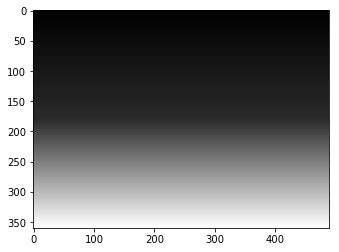

In [421]:
alpha = np.zeros((images[0].shape[0], 1))
for i in range(images[0].shape[0]):
    if i< images[0].shape[0]*0.5:
        alpha[i, 0] = 0.2*i/(images[0].shape[0]*0.5)
    else:
        alpha[i, 0] = 0.2 + (i-images[0].shape[0]*0.5)/(images[0].shape[0]*0.5)
alpha = np.repeat(alpha, images[0].shape[1], axis=1)
plt.imshow(alpha, 'gray')

In [423]:
def annotate_images(images, i, ref=0):
    (mean_x, mean_y), left_lines, right_lines, edges, img = extract_vanishing_point_and_edges(
        images[i],
        top_lines = 5,
        blur_size = 9,
        hough_treshold = 20,
        vanishing_box = [width*0.25, width*0.75, -height*0.25, height*0.75],
        edge_threshold = 10,
        theta_limit = 80,
        crop_top=0)
    display_edges_and_vanishing_point(img,edges,[*left_lines,
                                           *right_lines],
                                           (mean_x, mean_y), 10)
    print(mean_x-ref)
    return mean_x

In [424]:
interactive(lambda x: annotate_images(images, x, 202.5), x=(0, FRAME_COUNT-1))

interactive(children=(IntSlider(value=2, description='x', max=4), Output()), _dom_classes=('widget-interact',))